# main

Same as `src_01`, but with walls instead of periodic boundary conditions.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

mpl.rc("figure", dpi=150)
mpl.rc("figure", figsize=(4,4))

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':15,
    'ytick.labelsize':15,
    'axes.labelsize':20,
})

import os
import re

In [2]:
# extra stuff
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import math
from scipy.spatial import cKDTree  # For finding nearest neighbors

# formatting
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Sets limits for when to use scientific notation

In [3]:
# output directory
src_n = 4
dir = f'../data.lbm/0{src_n}/'
# dir = f'../src/0{src_n}/output.lbm/'

# all ticks are found using regular expressions
files = os.listdir(dir)
ticks = []

pattern = r'fluidTrj_(\d+)\.csv'

for file in files:
    match = re.search(pattern, file)
    if match:
        ticks.append(int(match.group(1)))
        
ticks.sort()

len(ticks)

101

# Fluid

In [4]:
def fluidOverview(df):
#     df = df.query('coordinate_y <= 10 & coordinate_y >= -10')
    # figure preparation
#     fig, axes = plt.subplots(figsize = (5,2.5))
    fig, axes = plt.subplots(1, 2, figsize = (6,2.7))

    fig.suptitle("neutral, $\\beta = 0$", fontsize=16)
#     fig.suptitle(f"$t = {df.time.values[0]:.2f}$", fontsize=16)
    fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar


    # Create a meshgrid for plotting
    x_unique = df['coordinate_x'].unique()
    y_unique = df['coordinate_y'].unique()
    X, Y = np.meshgrid(x_unique, y_unique)
    
    xmax = x_unique.max()
    xmin = x_unique.min()
    ymax = y_unique.max()
    ymin = y_unique.min()

    # first plot
    upperLim = 1e-3/2
    lowerLim = 0.
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(lowerLim, upperLim)

    axes[0].streamplot(X, Y, 
        df.fluidVelocity_x.unstack().values.transpose(),
        df.fluidVelocity_y.unstack().values.transpose(),
        density=0.85, linewidth=0.5, color="black",
    )
    
    
    axes[0].pcolormesh(X, Y,
        np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap, alpha = 0.85
    );
#     axes[0].tick_params(labelbottom=False)
    axes[0].set_xticks([xmin, 0, xmax])
    axes[0].set_xlabel("$x ~ (\\mathrm{\\mu m})$")
    axes[0].set_yticks([ymin, 0, ymax])
    axes[0].set_ylabel("$y ~ (\\mathrm{\\mu m})$")
    
    cbar_ax = fig.add_axes([0.9, 0.55, 0.025, 0.3])  # [left, bottom, width, height] for the colorbar
#     cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.85)
    cbar.set_label(label='$\\mathbf{u}$', fontsize=16)
#     cbar.set_label(label='$|\\mathbf{u}| ~ \\left(10^{-3}~\\mathrm{mm}/\\mathrm{s}\\right)$', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels([f'{tick:.4f}' for tick in custom_ticks])
#     cbar.set_ticklabels(['$0$','$1.5$','$3$'])
    
    # bottom plot
    epsilon = 0.001
    upperLim = 1. + epsilon
    lowerLim = 1. - epsilon
    cmap = plt.get_cmap('seismic')
    norm = plt.Normalize(lowerLim, upperLim)
    axes[1].pcolormesh(X,Y,
        df.massDensity.unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap,
    );
    axes[1].set_xticks([xmin, 0, xmax])
    axes[1].set_xlabel("$x ~ (\\mathrm{\\mu m})$")
    axes[1].set_yticks([ymin, 0, ymax])
    axes[1].tick_params(labelleft=False)
#     axes[1].set_ylabel("$y ~ (\\mathrm{mm})$")

    cbar_ax = fig.add_axes([0.9, 0.13, 0.025, 0.3])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label(label='$\\rho$', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    custom_ticks = np.array([lowerLim, 1 ,upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels(custom_ticks)
    cbar.set_ticklabels([f'{tick:.3f}' for tick in custom_ticks])
    
    return fig, axes

In [5]:
# id += 1
id = -1
fluidDf = pd.read_csv(dir + f"fluidTrj_{ticks[id]}.csv").set_index(["id_x","id_y"]).sort_index()

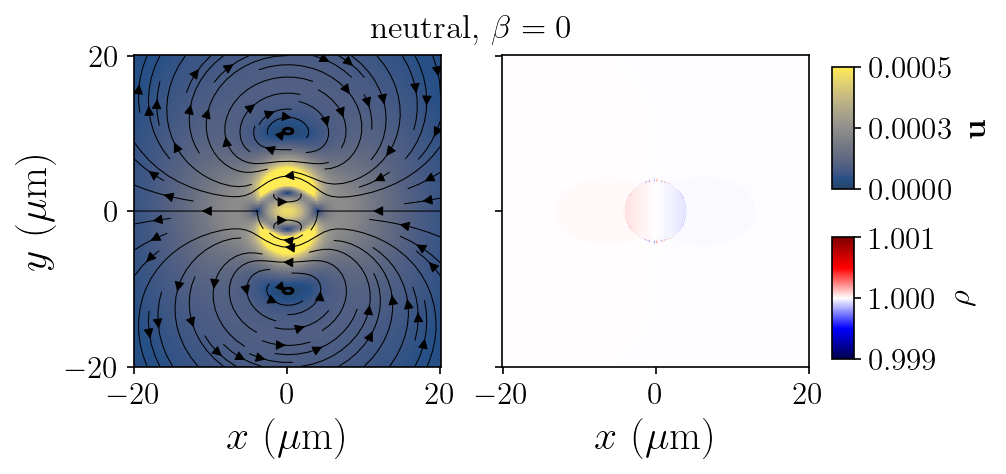

In [6]:
fig, axes = fluidOverview(fluidDf.query('coordinate_x**2 <= 20**2 & coordinate_y**2 <= 20**2'))
# plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")
plt.show()

In [7]:
def avgSpeed(df):
    return np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).mean()

In [8]:
try:
    avgFluidSpeed 
except NameError:
    avgFluidSpeed = []
    
try:
    time 
except NameError:
    time = []

for tick in ticks[len(time)::]:
    auxDf = pd.read_csv(dir + f"fluidTrj_{tick}.csv")
    avgFluidSpeed.append(avgSpeed(auxDf))
    time.append(auxDf.time.values[0])
    print(f'\r{tick}', end='', flush=True)
print('\r'+' '*10, end='', flush=True)

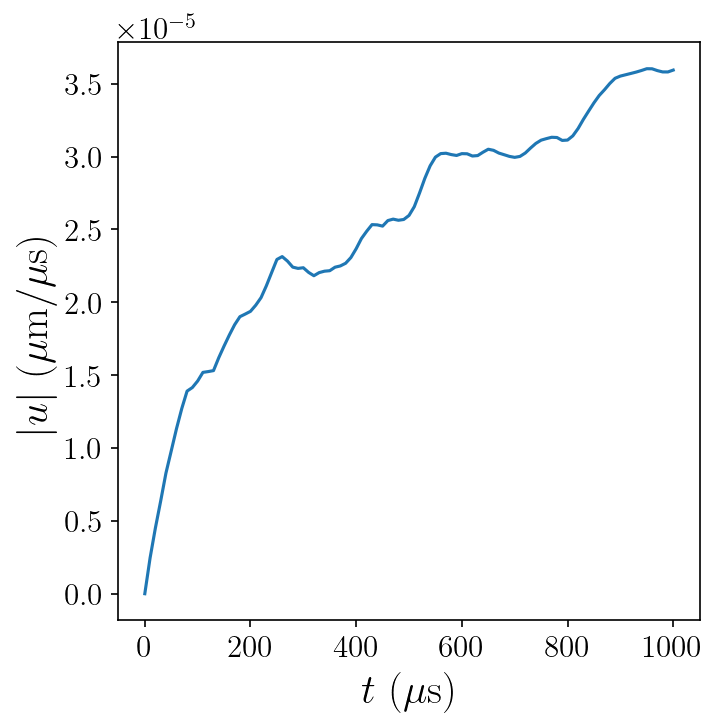

In [9]:
fig, ax = plt.subplots(figsize = (5,5))

ax.plot(time, avgFluidSpeed)
ax.set_xlabel("$t ~ (\\mu \\mathrm{s})$")
ax.set_ylabel("$|u| ~ (\\mu \\mathrm{m} / \\mu \\mathrm{s})$")

plt.show()

# Analytical results

In [10]:
def fluidOverview2(df):
#     df = df.query('coordinate_y <= 10 & coordinate_y >= -10')
    # figure preparation
#     fig, axes = plt.subplots(figsize = (5,2.5))
    fig, axes = plt.subplots(figsize = (3,2.7))

    fig.suptitle("Navier-Stokes solution", fontsize=16)
#     fig.suptitle(f"$t = {df.time.values[0]:.2f}$", fontsize=16)
    fig.subplots_adjust(right=0.875)  # Adjust the right space to make room for the colorbar


    # Create a meshgrid for plotting
    x_unique = df['coordinate_x'].unique()
    y_unique = df['coordinate_y'].unique()
    X, Y = np.meshgrid(x_unique, y_unique)
    
    xmax = x_unique.max()
    xmin = x_unique.min()
    ymax = y_unique.max()
    ymin = y_unique.min()

    # first plot
    upperLim = 1e-3 * 2/3 + 1e-4 # maximum fluid speed should be 2/3*1e-3
    lowerLim = 0.
    cmap = plt.get_cmap('cividis')
    norm = plt.Normalize(lowerLim, upperLim)

    axes.streamplot(X, Y, 
        df.fluidVelocity_x.unstack().values.transpose(),
        df.fluidVelocity_y.unstack().values.transpose(),
        density=0.85, linewidth=0.5, color="black",
    )
    
    
    axes.pcolormesh(X, Y,
        np.sqrt(df.fluidVelocity_x**2 + df.fluidVelocity_y**2).unstack().values.transpose(),
        vmin=lowerLim,
        vmax=upperLim,
        cmap=cmap, alpha = 0.85
    );
#     axes[0].tick_params(labelbottom=False)
    axes.set_xticks([xmin, 0, xmax])
    axes.set_xlabel("$x ~ (\\mathrm{\\mu m})$")
    axes.set_yticks([ymin, 0, ymax])
    axes.set_ylabel("$y ~ (\\mathrm{\\mu m})$")
    
#     cbar_ax = fig.add_axes([0.9, 0.55, 0.025, 0.3])  # [left, bottom, width, height] for the colorbar
    cbar_ax = fig.add_axes([0.9, 0.15, 0.025, 0.7])  # [left, bottom, width, height] for the colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, alpha=0.85)
    cbar.set_label(label='$\\mathbf{u}$', fontsize=16)
#     cbar.set_label(label='$|\\mathbf{u}| ~ \\left(10^{-3}~\\mathrm{mm}/\\mathrm{s}\\right)$', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    custom_ticks = np.array([lowerLim, upperLim/2, upperLim])
    cbar.set_ticks(custom_ticks)
    cbar.set_ticklabels([f'{tick:.4f}' for tick in custom_ticks])
#     cbar.set_ticklabels(['$0$','$1.5$','$3$'])
    
    return fig, axes

In [11]:
navierStokes = pd.read_csv('../data.lbm/analyticalResults/betaZero.csv').set_index(["id_x","id_y"]).sort_index()

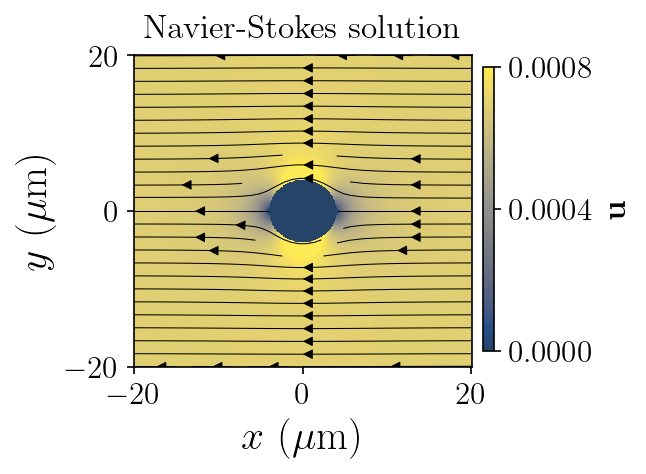

In [12]:
fig, axes = fluidOverview2(navierStokes.query('coordinate_x**2 <= 20**2 & coordinate_y**2 <= 20**2'))
# plt.savefig("figure1.png", format="png", transparent=True, dpi=1000, bbox_inches="tight")
plt.show()

# Stress tensor

In [13]:
stressDf = pd.read_csv(dir + "stressTensor.csv").set_index(["id_x","id_y"]).sort_index()

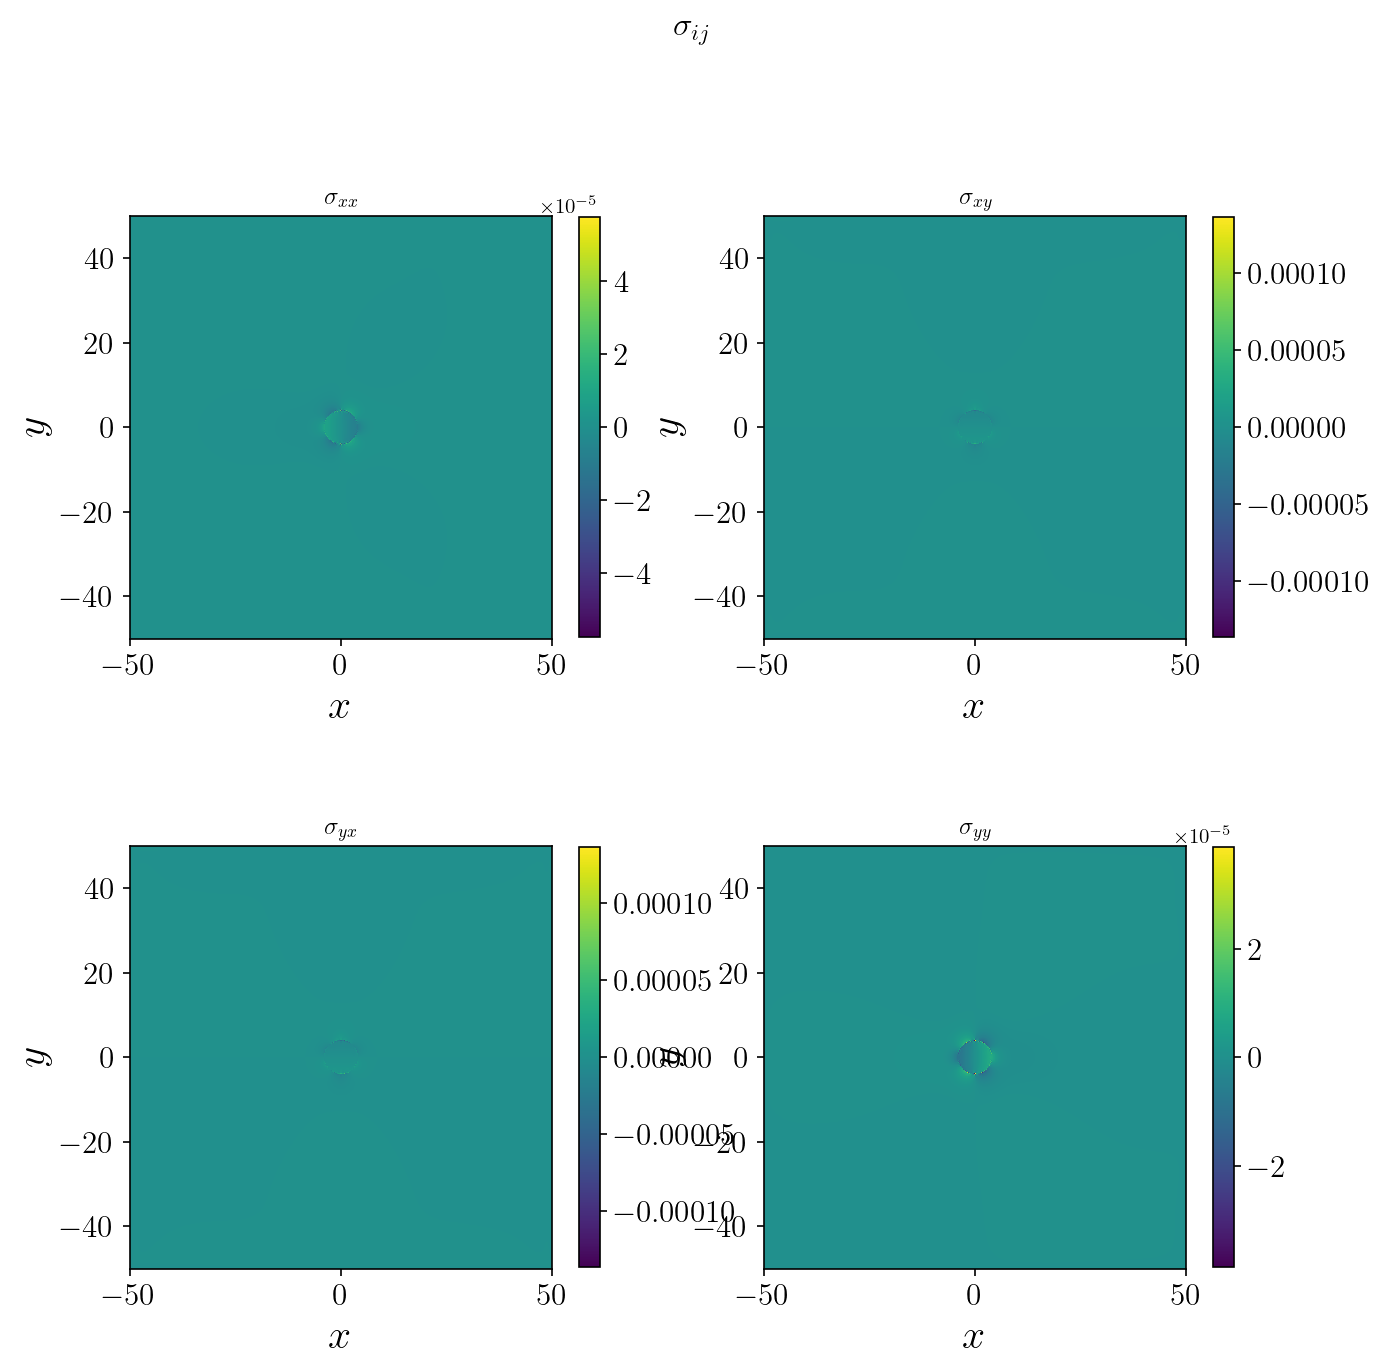

In [14]:
# setting up stuff
fig, axes = plt.subplots(2,2,figsize = (10,10))

# Add a title for the whole figure
fig.suptitle("$\\sigma_{ij}$", fontsize=16)

# Create a meshgrid for plotting
x_unique = stressDf['coordinate_x'].unique()
y_unique = stressDf['coordinate_y'].unique()
X, Y = np.meshgrid(x_unique, y_unique)

cs = []

# plotting
c = axes[0,0].pcolormesh(X,Y,stressDf["component_xx"].unstack().values.transpose()); cs.append(c);
axes[0,0].set_title("$\\sigma_{xx}$")

c = axes[0,1].pcolormesh(X,Y,stressDf["component_xy"].unstack().values.transpose()); cs.append(c);
axes[0,1].set_title("$\\sigma_{xy}$")

c = axes[1,0].pcolormesh(X,Y,stressDf["component_yx"].unstack().values.transpose()); cs.append(c);
axes[1,0].set_title("$\\sigma_{yx}$")

c = axes[1,1].pcolormesh(X,Y,stressDf["component_yy"].unstack().values.transpose()); cs.append(c);
axes[1,1].set_title("$\\sigma_{yy}$")


# for ax in axes.flat:
for i in range(4):
    ax = axes.flatten()[i]
    c = cs[i]
    ax.set_aspect('equal')
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")    
    cbar = fig.colorbar(c, ax=ax, shrink=.8)
    cbar.ax.yaxis.set_major_formatter(formatter)
    cbar.ax.yaxis.get_offset_text().set_fontsize(10)  # Adjust the font size if necessary
#     ax.axhline(wallPosition, color = "k", alpha = 0.1)
#     ax.axhspan(-2, wallPosition, color='gray', alpha=0.1)  # Shade the wall

plt.show()